# 18장 시퀀스 배열로 다루는 순환 신경망(RNN)

[<img src="https://raw.githubusercontent.com/taehojo/taehojo.github.io/master/assets/images/linktocolab.png" align="left"/> ](https://colab.research.google.com/github/taehojo/deeplearning/blob/master/colab/ch18-colab.ipynb)

## 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(test_split=0.2)

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [11]:
reuters.load_data()

((array([list([1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
         list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
         list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 

In [25]:
X_train[0]

[1,
 27595,
 28842,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [32]:
# 단어 인덱스 가져오기
word_index = reuters.get_word_index()

# 인덱스 단어 맞춘 딕셔너리 생성
index_word_dict = {index: word for word, index in word_index.items()}

# 첫 번째 뉴스 기사 디코딩
decoding = ' '.join([index_word_dict.get(i - 3, '') for i in X_train[0]])

print(decoding)

 mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [2]:
# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 [==============================] - 12s 17ms/step - loss: 2.2170 - accuracy: 0.4447 - val_loss: 2.0422 - val_accuracy: 0.5000
Epoch 2/200
450/450 [==============================] - 7s 16ms/step - loss: 1.8499 - accuracy: 0.5301 - val_loss: 1.8211 - val_accuracy: 0.5303
Epoch 3/200
450/450 [==============================] - 7s 16ms/step - loss: 1.7029 - accuracy: 0.5563 - val_loss: 1.7605 - val_accuracy: 0.5561
Epoch 4/200
450/450 [==============================] - 7s 16ms/step - loss: 1.5939 - accuracy: 0.5926 - val_loss: 1.7920 - val_accuracy: 0.5610
Epoch 5/200
450/450 [==============================] - 7s 16ms/step - loss: 1.4970 - accuracy: 0.6181 - val_loss: 1.5943 - val_accuracy: 0.6113
Epoch 6/200
450/450 [==============================] - 7s 16ms/step - loss: 1.3956 - accuracy: 0.6407 - val_loss: 1.4344 - val_accuracy: 0.6411
Epoch 7/200
450/450 [==============================] - 7s 16ms/step - loss: 1.2733 - accuracy: 0.6772 - val_loss: 1.3990 - val_accuracy

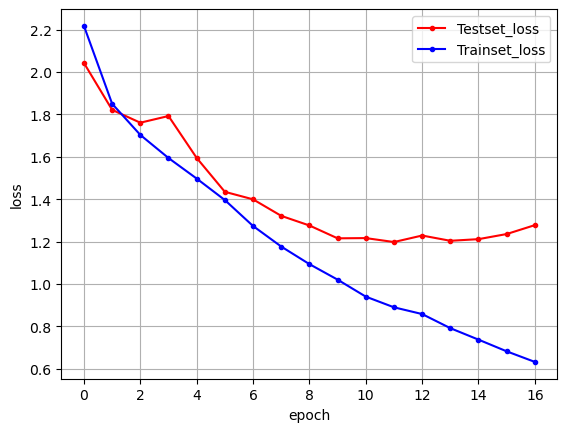

In [3]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17464789/17464789 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 55)                26400     
                                                                 
 dense_1 (Dense)             (None, 1)                 

In [5]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 14s 22ms/step - loss: 0.4074 - accuracy: 0.8033 - val_loss: 0.2780 - val_accuracy: 0.8856
Epoch 2/100
469/469 [==============================] - 10s 21ms/step - loss: 0.2382 - accuracy: 0.9075 - val_loss: 0.2746 - val_accuracy: 0.8861
Epoch 3/100
469/469 [==============================] - 10s 22ms/step - loss: 0.1841 - accuracy: 0.9325 - val_loss: 0.2651 - val_accuracy: 0.8926
Epoch 4/100
469/469 [==============================] - 10s 21ms/step - loss: 0.1532 - accuracy: 0.9441 - val_loss: 0.3062 - val_accuracy: 0.8789
Epoch 5/100
469/469 [==============================] - 10s 22ms/step - loss: 0.1251 - accuracy: 0.9562 - val_loss: 0.3299 - val_accuracy: 0.8715
Epoch 6/100
782/782 [==============================] - 6s 8ms/step - loss: 0.3350 - accuracy: 0.8760

 Test Accuracy: 0.8760


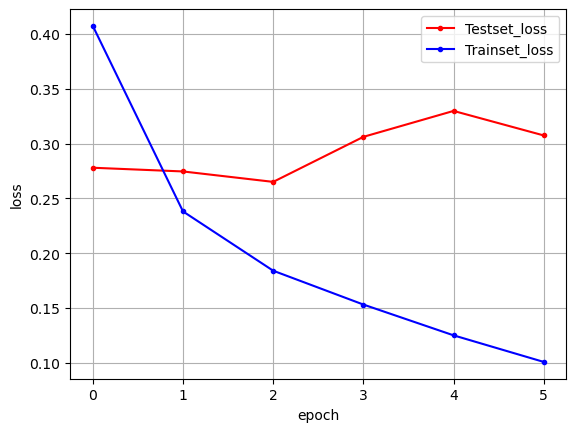

In [6]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 3. 어텐션을 사용한 신경망

In [7]:
!pip install attention

     -------------------------------------- 385.0/385.0 MB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 7.3 MB/s eta 0:00:00
     -------------------------------------- 126.6/126.6 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 7.0 MB/s eta 0:00:00
     -------------------------------------- 413.4/413.4 kB 8.6 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 7.3 MB/s eta 0:00:00
     -------------------------------------- 267.2/267.2 kB 8.3 MB/s eta 0:00:00
     -------------------------------------- 241.6/241.6 kB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 87.5/87.5 kB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-s

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\aopao\\.conda\\envs\\sashin\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

ModuleNotFoundError: No module named 'attention'

In [ ]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()